In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import wfdb
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from scipy.signal import butter, sosfilt, sosfreqz, ShortTimeFFT, get_window
import matplotlib.colors as mcolors


2024-12-14 19:30:27.724618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-14 19:30:27.743009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734233427.764917 3628504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734233427.771402 3628504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 19:30:27.793795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
path = '~/Desktop/ECGSignalClassifer/ptb-xl/'
dataset = pd.read_json(path+'updated_ptbxl_database.json')
dataset = dataset[['filename_lr', 'filename_hr', 'MI', 'STTC', 'CD', 'HYP', 'AD']]

In [3]:
leads = ['I', 'II', 'V2']
classes = ['MI', 'STTC', 'CD', 'HYP', 'AD']
batch_size = 32

# Multilabel Stratification
Since this is a mutli-label classification problem, it's important to split the data with respect to
each of the classes to ensure a well rounded training and testing run. This [repo](https://github.com/trent-b/iterative-stratification) implements this [paper](https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10), which is an iterative sampling method that is far better than random sample for problems like this. This package requires python 3.9 in order to work.

In [4]:
train_percentage = 0.70
test_percentage = 0.15
validation_percentage = 0.15

assert(train_percentage + test_percentage + validation_percentage == 1)

# Extract X and y
X = dataset[['filename_lr', 'filename_hr']]
y = dataset[['MI', 'STTC', 'CD', 'HYP', 'AD']]

# Train/Test split
splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=0)
train_indices, test_indices = next(splitter.split(X, y))

# Train/Validation split
splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=validation_percentage / (1 - test_percentage), random_state=0)
train_indices, validation_indices = next(splitter.split(X.iloc[train_indices], y.iloc[train_indices]))

# Assign splits
train_df = pd.concat([X.iloc[train_indices], y.iloc[train_indices]], axis=1)
validate_df = pd.concat([X.iloc[validation_indices], y.iloc[validation_indices]], axis=1)
test_df = pd.concat([X.iloc[test_indices], y.iloc[test_indices]], axis=1)

# Check split sizes
print(len(train_df), len(validate_df), len(test_df))

15243 3295 3261


# Data Loading Pipeline
In this section, we define a number of functions that will be used to efficiently load, transform and format the batches of signals. Using the rational discussed in this [paper](https://www.sciencedirect.com/science/article/pii/S174680942400199X#sec4), all but three leads from each signal sample will be dropped, keeping leads I, II and V2. This will save a computational cost and make the training more efficient. A band pass filter will then be applied to each signal to trim out baseline wander noise and high frequency noise above 45hz. A spectrogram operation will be applied to each lead, then the leads will be stacked on top of each other to create a (3, 1000, 45) matrix. This will be passed into the network.

1. Load only 3 leads of the signal
2. Apply bandpass filter
3. Apply spectrogram (STFT)
4. Combine signals into a matrix [signals, timesteps, frequency steps] (3, 1000, n) n is undecided for now

### 1: Loading the signals

In [5]:
def load_batch(df, path='ptb-xl/', sampling_rate=100):
    df_files = df.filename_lr if sampling_rate == 100 else df.filename_hr
    data = [
            wfdb.rdsamp(path+f, channel_names=leads, return_res=32)[0].T
            for f in df_files
        ]
    
    labels = df[classes].to_numpy()

    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    return data_tensor, labels_tensor

In [6]:
data, labels = load_batch(dataset[:32], path='ptb-xl/', sampling_rate=100)
print(data.shape)
print(labels)


(32, 3, 1000)
tf.Tensor(
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]], shape=(32, 5), dtype=float32)


W0000 00:00:1734233431.425314 3628504 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 2: Designing the bandpass filter
I have some background in signal processing due to my undergraduate degree in computer engineering. I had ChatGPT generate me some code to help design the filter.

/tmp/ipykernel_3628504/376590875.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w, 20 * np.log10(abs(h)))


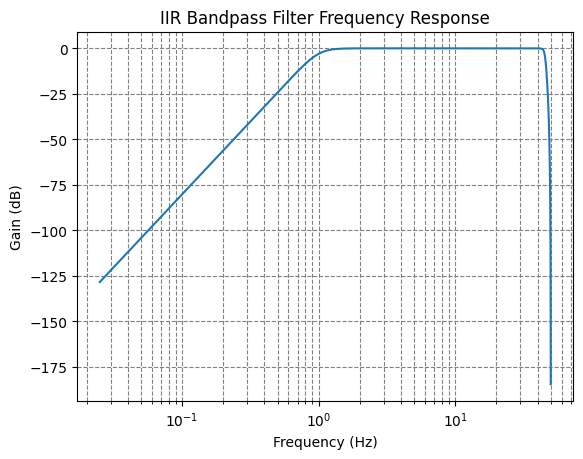

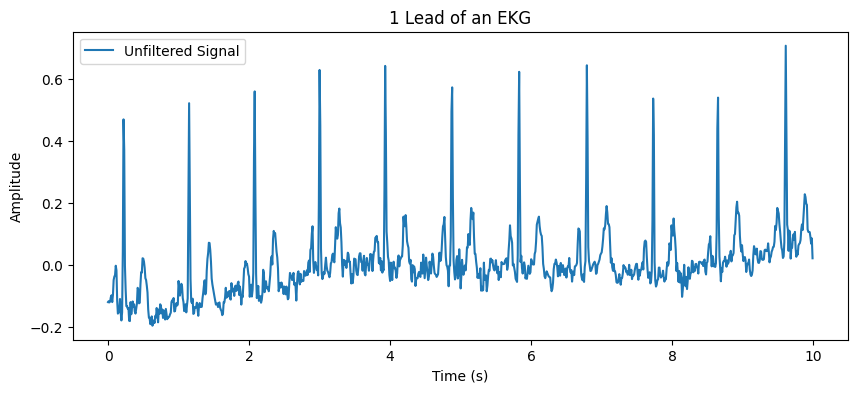

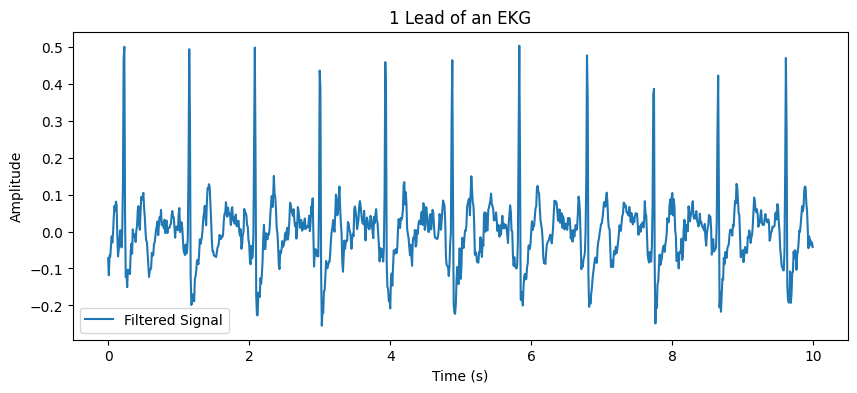

In [7]:
# Band pass filter
lowcut = 1.0          # Lower cutoff frequency (Hz)
highcut = 45.0        # Upper cutoff frequency (Hz)
fs = 100.0            # Sampling frequency (Hz)
order = 4             # Filter order (higher = steeper rolloff)

# Define the IIR bandpass filter
def design_iir_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')  # Second-order sections
    return sos

# Design the filter
sos = design_iir_bandpass(lowcut, highcut, fs, order)

# Visualize frequency response
w, h = sosfreqz(sos, worN=2000, fs=fs)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('IIR Bandpass Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid(which='both', linestyle='--', color='gray')
plt.show()

# Apply the filter to a signal (example)

def apply_filter(signal, sos):
    return sosfilt(sos, signal)

seconds = 10.0
t = np.linspace(0, seconds, int(fs * seconds), endpoint=False)  # 1 second of data
data, labels = load_batch(dataset.iloc[:1])
data = data[0][0][:int(fs * seconds)]
filtered_signal = apply_filter(data, sos)

# Plot original vs. filtered signal
# plt.plot(t, data, label="Original Signal")
plt.figure(figsize=(10,4))
plt.plot(t, data, label="Unfiltered Signal")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('1 Lead of an EKG')
plt.autoscale
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, filtered_signal, label="Filtered Signal")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('1 Lead of an EKG')
plt.autoscale
plt.legend()
plt.show()


### 3: Apply Spectrogram

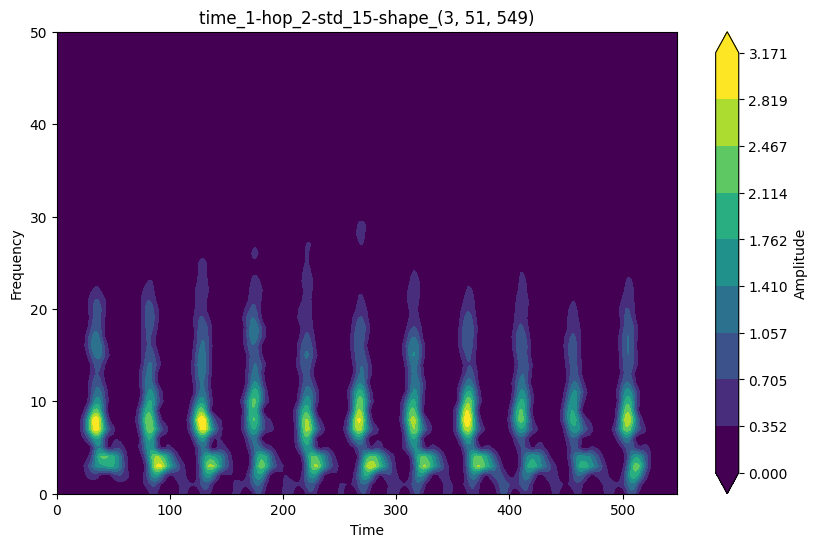

In [10]:
import itertools

time_length = [1]
hop = [2]
gaussian_std = [ 15]

combs = itertools.product(time_length, hop, gaussian_std)

for t, h, std in combs:

    # Standard deviation of 2
    nperseg = fs * t  # Length of each segment, 2 seconds in this case
    hop = h  # Overlap between segments, 50% hop in this case

    w = get_window(('gaussian', std), nperseg)
    sft = ShortTimeFFT(w, hop, fs=fs) #mfft=150)

    def apply_spectrogram(signal, sft=sft):
        spectrogram = sft.spectrogram(signal)
        return spectrogram

    def preprocess_batch(df, sos, sft, sampling_rate=fs):
        # Load data and labels
        data, labels = load_batch(df, sampling_rate=sampling_rate)
        filtered_data = sosfilt(sos, data, axis=-1)
        spectrogram_data = np.apply_along_axis(func1d=apply_spectrogram, axis=2, arr=filtered_data, sft=sft)
        
        return spectrogram_data, labels

    data, labels = preprocess_batch(dataset[:1], sos, sft)
    shape = data.shape[1:]

    title = f"time_{t}-hop_{h}-std_{std}-shape_{shape}"

    # Define a discrete colormap
    levels = np.linspace(data[0][0].min(), data[0][0].max(), 10)  # Adjust number of levels
    cmap = mcolors.ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(levels) - 1)))

    # Plot with the discrete colormap
    plt.figure(figsize=(10, 6))
    plt.contourf(data[0][0], levels=levels, cmap=cmap, extend='both')
    plt.colorbar(label='Amplitude', ticks=levels)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, gaussian, get_window

# Generate a test signal (a sum of two sine waves)
fs = 1000  # Sampling frequency
t = np.linspace(0, 2, 2 * fs, endpoint=False)  # Time array
signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t)

# Parameters for visualization
hop_sizes = [32, 128, 256]  # Different hop sizes
nperseg_values = [128, 256, 512]  # Different segment sizes
gaussian_stds = [7, 15, 30]  # Standard deviations for Gaussian window

# Create figure for visualization
fig, axes = plt.subplots(len(hop_sizes), len(nperseg_values), figsize=(15, 10))
fig.suptitle('Time-Frequency Tradeoff and Data Shape with STFT Parameters', fontsize=16)

for i, hop_size in enumerate(hop_sizes):
    for j, nperseg in enumerate(nperseg_values):
        # Generate a Gaussian window with a specific standard deviation
        std = gaussian_stds[min(i, len(gaussian_stds) - 1)]
        window = get_window(('gaussian', std), nperseg)
        
        # Compute the spectrogram
        f, t, Sxx = spectrogram(signal, fs=fs, window=window, noverlap=nperseg - hop_size, nperseg=nperseg)
        
        # Plot the spectrogram
        ax = axes[i, j]
        ax.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
        ax.set_title(f"Hop: {hop_size}, Nperseg: {nperseg}, σ: {std}")
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_ylim(0, 200)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
plt.show()

ImportError: cannot import name 'gaussian' from 'scipy.signal' (/home/lrbutler/.local/lib/python3.10/site-packages/scipy/signal/__init__.py)